In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("main_df_sunderbans.csv")
cols = data.columns

In [3]:
data_main = data[cols[:3]]
data_main.head(3)

,Year,Month,mean
0,1993,1,-9.852119
1,1993,2,-9.963833
2,1993,3,-9.856525


In [4]:
data = data_main.copy()

data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

data.set_index('Date', inplace=True)

In [5]:
data_new = pd.DataFrame({'Date': data.index, 'mean': data['mean']})

data_new = data_new[data_new['mean'] >= -50]

data_new.head(5)

,Date,mean
Date,,
1993-01-01,1993-01-01,-9.852119
1993-02-01,1993-02-01,-9.963833
1993-03-01,1993-03-01,-9.856525
1993-04-01,1993-04-01,-9.925649
1993-05-01,1993-05-01,-9.439488


In [55]:
time_series = data_new['mean']

scaler = MinMaxScaler(feature_range=(0, 1))

time_series_scaled = scaler.fit_transform(time_series.values.reshape(-1, 1))
time_series_scaled = pd.Series(time_series_scaled.flatten(), index=time_series.index)

train_size = int(len(time_series_scaled) * 0.8)
validation_size = int(len(time_series_scaled) * 0.9)

train = time_series_scaled[:train_size]
validation = time_series_scaled[train_size:validation_size]
test = time_series_scaled[validation_size:]



In [56]:
model = SARIMAX(train, order=(1, 0, 2), seasonal_order=(1, 0, 2, 12))
model_fit = model.fit(disp=False)


In [57]:

predictions_scaled_train = model_fit.forecast(steps=len(validation))


In [58]:
predictions_scaled_train.head(3)

265    0.351243
266    0.350288
267    0.476659
Name: predicted_mean, dtype: float64

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from sklearn.metrics import mean_absolute_percentage_error


p = d = q = range(0, 3)  # You can adjust these ranges as needed


pdq = list(itertools.product(p, d, q))

best_mape = float('inf')
best_order = None

warnings.filterwarnings('ignore')  

for order in pdq:
    try:
        # Fit the SARIMAX model
        model = SARIMAX(train, order=order, seasonal_order=(1, 0, 2, 12))  
        model_fit = model.fit(disp=False)

        # Forecast and calculate MAPE
        predictions_scaled_train = model_fit.forecast(steps=len(validation))
        mape = mean_absolute_percentage_error(validation, predictions_scaled_train)

        # Update the best MAPE and order
        if mape < best_mape:
            best_mape = mape
            best_order = order


        print(f'Current Order: {order}, Current MAPE: {mape}, Best Order So Far: {best_order}, Best MAPE So Far: {best_mape}')

    except:
        continue


print(f'\nFinal Best SARIMAX Order: {best_order}')
print(f'Final Best MAPE: {best_mape}')


Current Order: (0, 0, 0), Current MAPE: 0.1279235726725965, Best Order So Far: (0, 0, 0), Best MAPE So Far: 0.1279235726725965
Current Order: (0, 0, 1), Current MAPE: 0.1310508646155753, Best Order So Far: (0, 0, 0), Best MAPE So Far: 0.1279235726725965
Current Order: (0, 0, 2), Current MAPE: 0.12921174344321384, Best Order So Far: (0, 0, 0), Best MAPE So Far: 0.1279235726725965
Current Order: (0, 1, 0), Current MAPE: 0.2441386929416769, Best Order So Far: (0, 0, 0), Best MAPE So Far: 0.1279235726725965
Current Order: (0, 1, 1), Current MAPE: 0.2668915140905226, Best Order So Far: (0, 0, 0), Best MAPE So Far: 0.1279235726725965
Current Order: (0, 1, 2), Current MAPE: 0.11292827427296016, Best Order So Far: (0, 1, 2), Best MAPE So Far: 0.11292827427296016
Current Order: (0, 2, 0), Current MAPE: 1.7560501957210806, Best Order So Far: (0, 1, 2), Best MAPE So Far: 0.11292827427296016
Current Order: (0, 2, 1), Current MAPE: 0.2377302776616231, Best Order So Far: (0, 1, 2), Best MAPE So Far:

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(validation, predictions_scaled_train)
mape

0.11279169088589105

In [52]:
predictions_test = model_fit.forecast(steps=len(test))

In [53]:
mape_test = mean_absolute_percentage_error(test, predictions_test)

Mean Absolute Percentage Error (MAPE) is: 0.22455855782489356


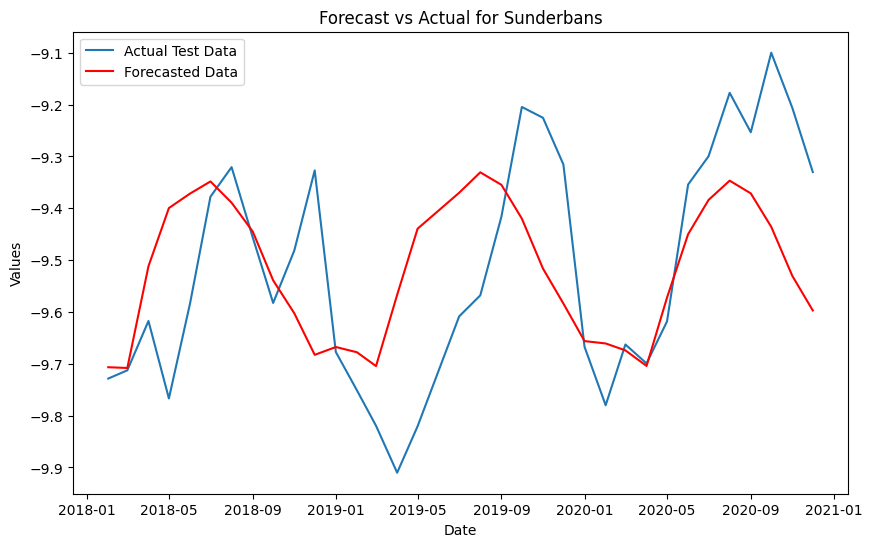

In [62]:
import matplotlib.pyplot as plt

print(f'Mean Absolute Percentage Error (MAPE) is: {mape_test}')

test_actual = scaler.inverse_transform(test.values.reshape(-1, 1))

test_actual_predictions = scaler.inverse_transform(predictions_test.values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test_actual, label='Actual Test Data')
plt.plot(test.index, test_actual_predictions, label='Forecasted Data', color='red')


plt.title('Forecast vs Actual for Sunderbans')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.show()
